# ML Models

In [24]:
import pandas as pd

# Load the dataset
file_path = 'SP500_Last_10_Years.csv'
sp500_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
sp500_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-04-21,1865.790039,1871.890015,1863.180054,1871.890015,1871.890015,2642500000
1,2014-04-22,1872.569946,1884.890015,1872.569946,1879.550049,1879.550049,3215440000
2,2014-04-23,1879.319946,1879.750000,1873.910034,1875.390015,1875.390015,3085720000
3,2014-04-24,1881.969971,1884.060059,1870.239990,1878.609985,1878.609985,3191830000
4,2014-04-25,1877.719971,1877.719971,1859.699951,1863.400024,1863.400024,3213020000


In [25]:
from datetime import datetime

# Convert 'Date' to datetime
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])

# Check the first and last date to understand the range
sp500_data['Date'].min(), sp500_data['Date'].max()


(Timestamp('2014-04-21 00:00:00'), Timestamp('2024-04-17 00:00:00'))

In [26]:
sp500_data.shape

(2516, 7)

In [27]:
from sklearn.model_selection import train_test_split

# Calculate the cutoff date for 8 years of training
cutoff_date_train = datetime(2022, 4, 21)

# Filter the dataset for training and testing based on the cutoff date
train_data = sp500_data[sp500_data['Date'] < cutoff_date_train]
test_data = sp500_data[sp500_data['Date'] >= cutoff_date_train]

# Creating lagged features for the past 30 days
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
X = []
y = []

for i in range(30, len(train_data)):
    X.append(train_data[features].iloc[i-30:i].values)
    y.append(train_data['Open'].iloc[i])

# Converting to numpy arrays
import numpy as np
X_train = np.array(X)
y_train = np.array(y)

# Prepare the test set in similar fashion
X_test = []
y_test = []

for i in range(30, len(test_data)):
    X_test.append(test_data[features].iloc[i-30:i].values)
    y_test.append(test_data['Open'].iloc[i])

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((1986, 30, 6), (1986,), (470, 30, 6), (470,))

## Xgboost

In [28]:
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import linear_model

# Flatten the inputs for SVM since it does not handle 3D input natively
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Standardize features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

In [29]:
# Initialize models
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Train XGBoost
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Flatten for XGB

# Predictions
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluation metrics
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)


(xgb_rmse, xgb_r2)

(127.40792134175166, 0.9042794668185066)

## Bayesian Ridge

In [30]:
BayesianRidge = linear_model.BayesianRidge()

# Train SVM
BayesianRidge.fit(X_train_scaled, y_train)

BayesianRidge_predictions = BayesianRidge.predict(X_test_scaled)

BayesianRidge_rmse = np.sqrt(mean_squared_error(y_test, BayesianRidge_predictions))
BayesianRidge_r2 = r2_score(y_test, BayesianRidge_predictions)


(BayesianRidge_rmse, BayesianRidge_r2)


(21.955723130350304, 0.9971574524413771)

## SVM

In [32]:
SVR_model = SVR()

# Train SVM
SVR_model.fit(X_train_scaled, y_train)

SVR_model_predictions = SVR_model.predict(X_test_scaled)

SVR_model_rmse = np.sqrt(mean_squared_error(y_test,SVR_model_predictions))
SVR_model_r2 = r2_score(y_test, SVR_model_predictions)


(SVR_model_rmse, SVR_model_r2)

(1311.0335088766356, -9.135375250424241)

## Comparisons

In [37]:
import json
model_performance = {}

model_performance['models']=["XGBoost",'BayesianRidge','SVM']
model_performance['RMSE']=[xgb_rmse,BayesianRidge_rmse,SVR_model_rmse]
model_performance['R2']=[xgb_r2,BayesianRidge_r2,SVR_model_r2]


In [38]:
# Print the results from the dictionary
model_performance

{'models': ['XGBoost', 'BayesianRidge', 'SVM'],
 'RMSE': [127.40792134175166, 21.955723130350304, 1311.0335088766356],
 'R2': [0.9042794668185066, 0.9971574524413771, -9.135375250424241]}

In [39]:



# Save the results to a JSON file
with open('ml_model_performance_results.json', 'w') as file:
    json.dump(model_performance, file, indent=4)



## Visualizations

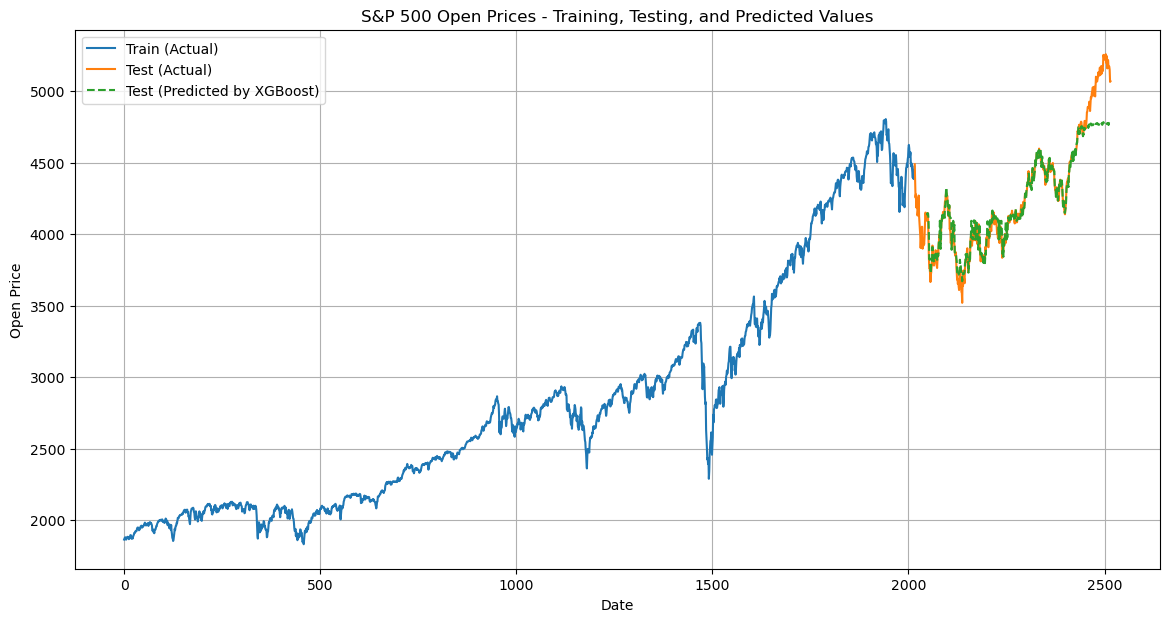

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Open'], label='Train (Actual)')
plt.plot(test_data.index, test_data['Open'], label='Test (Actual)')
plt.plot(test_data.index[30:], xgb_predictions, label='Test (Predicted by XGBoost)', linestyle='--')
plt.title('S&P 500 Open Prices - Training, Testing, and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)

plt.show()


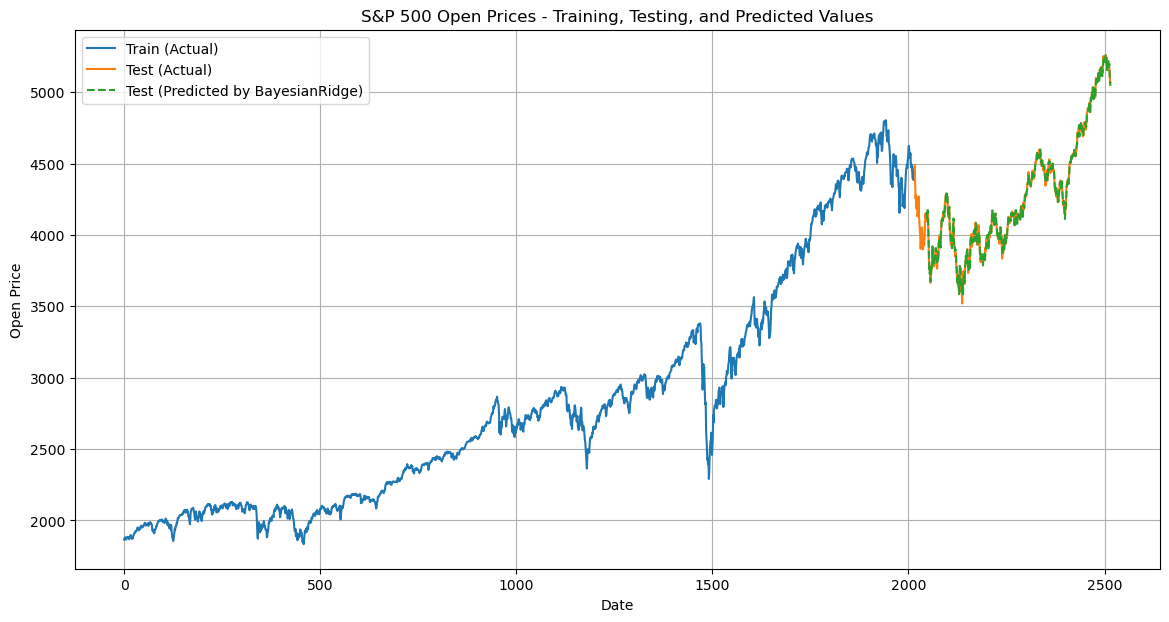

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Open'], label='Train (Actual)')
plt.plot(test_data.index, test_data['Open'], label='Test (Actual)')
plt.plot(test_data.index[30:], BayesianRidge_predictions, label='Test (Predicted by BayesianRidge)', linestyle='--')
plt.title('S&P 500 Open Prices - Training, Testing, and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)
plt.show()

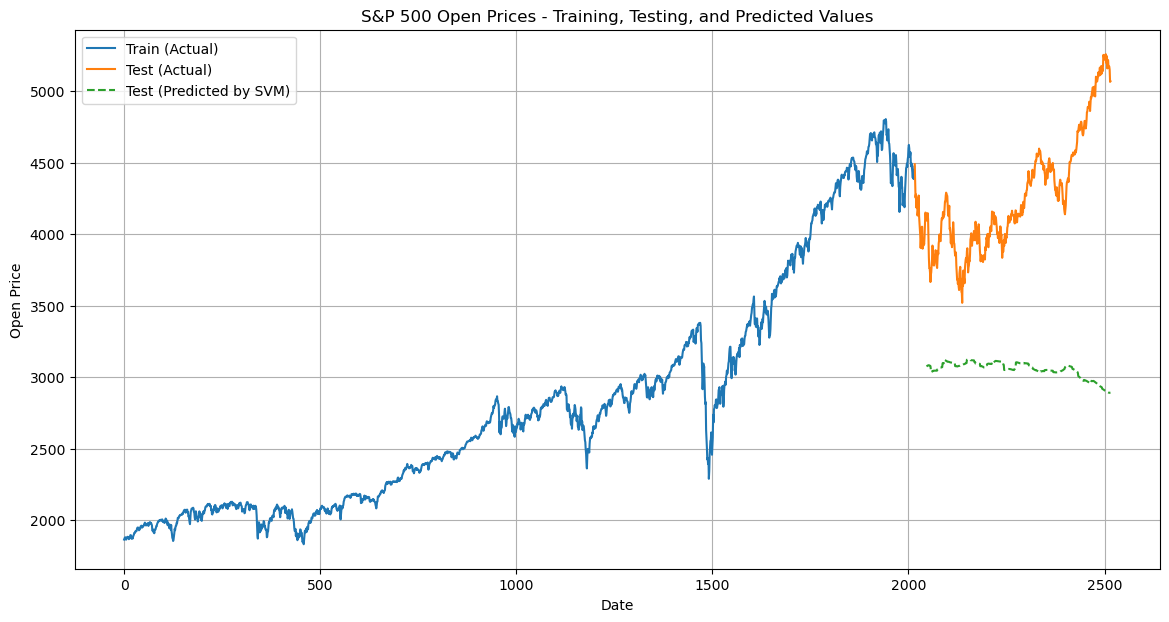

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Open'], label='Train (Actual)')
plt.plot(test_data.index, test_data['Open'], label='Test (Actual)')
plt.plot(test_data.index[30:], SVR_model_predictions, label='Test (Predicted by SVM)', linestyle='--')
plt.title('S&P 500 Open Prices - Training, Testing, and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)

plt.show()